# O Problema do Caxeiro Viajante
<b>SME0110 - Programação Matemática || Bach. Ciências de Computação || ICMC/USP<br>
Alunos: João Garcia Coelho (10349540) & Matheus AParecido do Carmo Alves (9791114)</b>

Este projeto tem como propostao estudar e implementar o modelo para resolução do problema do caixeiro viajante com as restrições de eliminação de sub-rotas do tipo MTZ (Otimização Inteira Mista).

Para a realização de testes e estudo, será utilizado o conjunto de dados <a href='https://wwwproxy.iwr.uni-heidelberg.de/groups/comopt/software/TSPLIB95/tsp/burma14.tsp.gz'>Burma14</a> e outras três <a href='http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/index.html'>instâncias disponíveis</a>,  sendo elas: "ulysses16", "bays29" e "berlin52".

## 1. Instalando e carregando pacotes necessários

Primeiramente, iremos instalar (caso necessário) e incluir os pacotes necessários para a execução do projeto.
Serão eles:
<ul>
    <li><b>JuMP</b>: Pacote de modelos para otimização matemática em Julia.</li>
    <li><b>CBC</b>: Pacote para programação linear para Julia.</li>
    <li><b>Distances</b>: Pacote para calculo de distâncias em Julia.</li>
    <li><b>Plots e Graphs Recipes</b>: Pacotes para desenhar o grafo montado.</li>
    <li><b>LightGraphs e SimpleWeightedGraphs</b>: Pacotes para montar grafos.</li>
</ul>

Para isso, usamos o seguintes comandos:

In [16]:
# Installing the packages
using Pkg
#Pkg.add("JuMP")
#Pkg.add("Cbc")
#Pkg.add("Distances")
#Pkg.add("Plots")
#Pkg.add("GraphRecipes")
#Pkg.add("LightGraphs")
#Pkg.add("SimpleWeightedGraphs")

# Including the packages
using JuMP, Distances, Plots, GraphRecipes, LightGraphs, SimpleWeightedGraphs, Cbc

Agora, vamos a resolução dos problemas do caixeiro viajante. 

## Burma14

Primeiramente, vamos carregar o arquivo de estudo para construção do problema.

In [17]:
file_name = "burma14.txt"

# 1. Carregando o arquivo de estudo
file = open("./" * file_name);
lines = readlines(file)
N = length(lines)

println("Numero de nós: ", N)

Numero de nós: 14


Com o arquivo carregado, iremos formatar os dados, extraindo as informações que desejamos.

O primeiro passo é extrair as informações do arquivo de entrada:

In [18]:
# 2. Extraindo as informações do arquivo de entrada
c = [Vector{Float64}(undef, 2) for _ in 1:N]

for i = 1:N
    x, y = split(lines[i],',')
    c[i] = [parse(Float64, x), parse(Float64, y)]
end

Extraída as informações, iremos calcular a matriz de distâncias.

In [19]:
# 3. Calculando a matriz de distancias
dist_mat = zeros(N,N)
for i=1:N, j=i+1:N
    d = euclidean(c[i],c[j])
    dist_mat[i,j] = d
    dist_mat[j,i] = d
end

Podemos visualizar a rede a qual estamos trabalhando da seguinte forma:

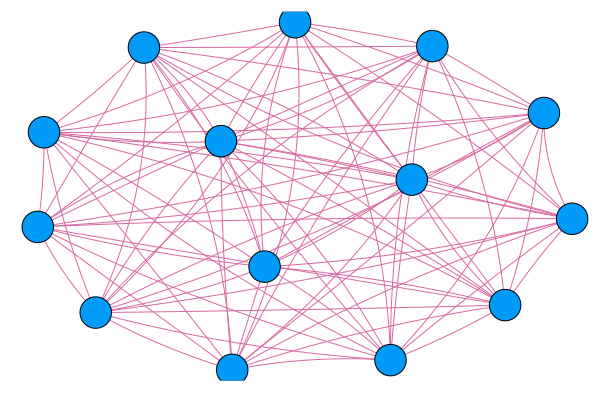

In [20]:
# 4. Plotando o grafo do problema
g = WGraph(N)
for i = 1:N
    for j = i+1:N
        add_edge!(g, i, j, dist_mat[i,j])
    end
end
graphplot(g)

Agora iremos criar o modelo para resolução do problema.

In [21]:
# 5. Realizando a otimização inteira mista - MTZ
m = Model(with_optimizer(Cbc.Optimizer, logLevel=1))

@variable(m, x[1:N,1:N], Bin)
@variable(m, u[1:N], Int)
@objective(m, Min, sum(x[i,j]*dist_mat[i,j] for i=1:N,j=1:N))
for i=1:N 
    @constraint(m, x[i,i] == 0)
    @constraint(m, sum(x[i,1:N]) == 1)
end
for j=1:N
    @constraint(m, sum(x[1:N,j]) == 1)
end
for f=1:N, t=1:N
    @constraint(m, x[f,t]+x[t,f] <= 1)
end
for i = 2:N
    @constraint(m, u[i] >= 2)
end
for i = 2:N, j = 2:N
    if i != j
        @constraint(m, u[i] - u[j] +N*x[i,j] <= N-1)
    end 
end
optimize!(m)
println("Resultado da função objetivo: ", JuMP.objective_value(m))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Oct  7 2019 

command line - Cbc_C_Interface -logLevel 1 -solve -quit (default strategy 1)
Continuous objective value is 28.4602 - 0.00 seconds
Cgl0002I 14 variables fixed
Cgl0003I 0 fixed, 13 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0004I processed model has 275 rows, 195 columns (195 integer (182 of which binary)) and 1014 elements
Cbc0031I 14 added rows had average density of 163.14286
Cbc0013I At root node, 14 cuts changed objective from 28.460153 to 28.460153 in 100 passes
Cbc0014I Cut generator 0 (Probing) - 0 row cuts average 0.0 elements, 0 column cuts (7 active)  in 0.266 seconds - new frequency is -100
Cbc0014I Cut generator 1 (Gomory) - 923 row cuts average 162.7 elements, 0 column cuts (0 active)  in 0.209 seconds - new frequency is -100
Cbc0014I Cut generator 2 (Knapsack) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.048 seconds - new frequency is -100
Cbc0014I Cut generator 3

Vizando generalizar o código, podemos criar a seguinte função para execução da otimização do problema do caixeiro viajante.

In [22]:
function tsp(file_name)
    # 1. Carregando o arquivo de estudo
    file = open(file_name);
    lines = readlines(file)
    N = length(lines)
    println("Numero de nós: ", N)
    
    # 2. Extraindo as informações do arquivo de entrada
    c = [Vector{Float64}(undef, 2) for _ in 1:N]
    for i = 1:N
        x, y = split(lines[i],',')
        c[i] = [parse(Float64, x), parse(Float64, y)]
    end
    
    # 3. Calculando a matriz de distancias
    dist_mat = zeros(N,N)
    for i=1:N, j=i+1:N
        d = euclidean(c[i],c[j])
        dist_mat[i,j] = d
        dist_mat[j,i] = d
    end
    
    # 4. Plotando o grafo do problema
    g = WGraph(N)
    for i = 1:N
        for j = i+1:N
            add_edge!(g, i, j, dist_mat[i,j])
        end
    end
    graphplot(g)
    
    # 5. Realizando a otimização inteira mista - MTZ
    m = Model(with_optimizer(Cbc.Optimizer, logLevel=1))

    @variable(m, x[1:N,1:N], Bin)
    @variable(m, u[1:N], Int)
    @objective(m, Min, sum(x[i,j]*dist_mat[i,j] for i=1:N,j=1:N))
    for i=1:N 
        @constraint(m, x[i,i] == 0)
        @constraint(m, sum(x[i,1:N]) == 1)
    end
    for j=1:N
        @constraint(m, sum(x[1:N,j]) == 1)
    end
    for f=1:N, t=1:N
        @constraint(m, x[f,t]+x[t,f] <= 1)
    end
    for i = 2:N
        @constraint(m, u[i] >= 2)
    end
    for i = 2:N, j = 2:N
        if i != j
            @constraint(m, u[i] - u[j] +N*x[i,j] <= N-1)
        end 
    end
    
    optimize!(m)
    println("Resultado da função objetivo: ", JuMP.objective_value(m))
    
end

tsp (generic function with 1 method)

Como já possuímos a função genérica, podemos verificar facilmente a solução de outros datasets a partir desta.

Desta forma, iremos aplicar este método sobre os outros 3 datasets mencionados na introdução.

## Ulysses16

In [23]:
tsp("./ulysses16.txt")

Numero de nós: 16
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Oct  7 2019 

command line - Cbc_C_Interface -logLevel 1 -solve -quit (default strategy 1)
Continuous objective value is 63.1789 - 0.00 seconds
Cgl0002I 16 variables fixed
Cgl0003I 0 fixed, 15 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0004I processed model has 362 rows, 255 columns (255 integer (240 of which binary)) and 1350 elements
Cbc0031I 14 added rows had average density of 209.92857
Cbc0013I At root node, 14 cuts changed objective from 63.17888 to 65.154249 in 100 passes
Cbc0014I Cut generator 0 (Probing) - 14 row cuts average 142.9 elements, 0 column cuts (0 active)  in 0.390 seconds - new frequency is -100
Cbc0014I Cut generator 1 (Gomory) - 1203 row cuts average 194.9 elements, 0 column cuts (0 active)  in 0.296 seconds - new frequency is 1
Cbc0014I Cut generator 2 (Knapsack) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.059 seconds - new frequency is -100
Cbc001

## Bays29

In [24]:
tsp("./bays29.txt")

Numero de nós: 29
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Oct  7 2019 

command line - Cbc_C_Interface -logLevel 1 -solve -quit (default strategy 1)
Continuous objective value is 8644.7 - 0.01 seconds
Cgl0002I 29 variables fixed
Cgl0003I 0 fixed, 28 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0004I processed model has 1220 rows, 840 columns (840 integer (812 of which binary)) and 4704 elements
Cbc0031I 29 added rows had average density of 326.03448
Cbc0013I At root node, 29 cuts changed objective from 8644.6966 to 8972.5243 in 10 passes
Cbc0014I Cut generator 0 (Probing) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.135 seconds - new frequency is -100
Cbc0014I Cut generator 1 (Gomory) - 234 row cuts average 421.4 elements, 0 column cuts (0 active)  in 0.160 seconds - new frequency is 1
Cbc0014I Cut generator 2 (Knapsack) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.020 seconds - new frequency is -100
Cbc0014I C

## Berlin52

In [25]:
tsp("./berlin52.txt")

Numero de nós: 52
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Oct  7 2019 

command line - Cbc_C_Interface -logLevel 1 -solve -quit (default strategy 1)
Continuous objective value is 7166.3 - 0.05 seconds
Cgl0002I 52 variables fixed
Cgl0003I 0 fixed, 51 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0004I processed model has 3980 rows, 2703 columns (2703 integer (2652 of which binary)) and 15606 elements
Cbc0031I 51 added rows had average density of 474.52941
Cbc0013I At root node, 51 cuts changed objective from 7166.3007 to 7167.1996 in 10 passes
Cbc0014I Cut generator 0 (Probing) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.505 seconds - new frequency is -100
Cbc0014I Cut generator 1 (Gomory) - 147 row cuts average 742.0 elements, 0 column cuts (0 active)  in 0.543 seconds - new frequency is -100
Cbc0014I Cut generator 2 (Knapsack) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.007 seconds - new frequency is -100
Cbc

Cbc0010I After 19700 nodes, 229 on trResultado da função objetivo: 7544.365901904089
ee, 7544.3659 best solution, best possible 7463.693 (1293.46 seconds)
Cbc0010I After 19800 nodes, 195 on tree, 7544.3659 best solution, best possible 7476.1029 (1302.88 seconds)
Cbc0010I After 19900 nodes, 167 on tree, 7544.3659 best solution, best possible 7485.5166 (1311.33 seconds)
Cbc0010I After 20000 nodes, 141 on tree, 7544.3659 best solution, best possible 7496.8736 (1318.13 seconds)
Cbc0010I After 20100 nodes, 116 on tree, 7544.3659 best solution, best possible 7506.7295 (1327.55 seconds)
Cbc0010I After 20200 nodes, 84 on tree, 7544.3659 best solution, best possible 7518.2245 (1334.61 seconds)
Cbc0010I After 20300 nodes, 54 on tree, 7544.3659 best solution, best possible 7526.8426 (1341.84 seconds)
Cbc0010I After 20400 nodes, 20 on tree, 7544.3659 best solution, best possible 7535.5335 (1347.52 seconds)
Cbc0001I Search completed - best objective 7544.365901904089, took 1571956 iterations and 20